<a href="https://colab.research.google.com/github/srushtidayanand/MAML_Meta-learning/blob/Reptile/Reptile_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Meta Step 0] Meta-updated generator & discriminator.
[Meta Step 20] Meta-updated generator & discriminator.
[Meta Step 40] Meta-updated generator & discriminator.
[Meta Step 60] Meta-updated generator & discriminator.
[Meta Step 80] Meta-updated generator & discriminator.
[Meta Step 100] Meta-updated generator & discriminator.
[Meta Step 120] Meta-updated generator & discriminator.
[Meta Step 140] Meta-updated generator & discriminator.
[Meta Step 160] Meta-updated generator & discriminator.
[Meta Step 180] Meta-updated generator & discriminator.
[Meta Step 200] Meta-updated generator & discriminator.
[Meta Step 220] Meta-updated generator & discriminator.
[Meta Step 240] Meta-updated generator & discriminator.
[Meta Step 260] Meta-updated generator & discriminator.
[Meta Step 280] Meta-updated generator & discriminator.
[Meta Step 300] Meta-updated generator & discriminator.
[Meta Step 320] Meta-updated generator & discriminator.
[Meta Step 340] Meta-updated generator & discriminator

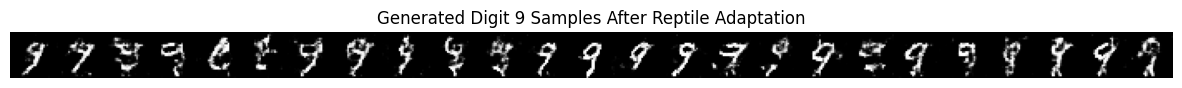

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Simple CNN Generator & Discriminator
# -----------------------------
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*7*7)
        self.bn1 = nn.BatchNorm1d(128*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.bn1(x)
        x = torch.relu(x)
        x = x.view(-1, 128, 7, 7)
        return self.deconv(x)

class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(128*7*7, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        return self.sigmoid(self.fc(x))

# -----------------------------
# Reptile-GAN Class
# -----------------------------
class Reptile_GAN:
    def __init__(self, latent_dim=100, inner_lr=0.025, meta_lr=0.01):
        self.latent_dim = latent_dim
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr

        self.generator = CNNGenerator(latent_dim).to(device)
        self.discriminator = CNNDiscriminator().to(device)

    def inner_loop(self, gen, disc, loader, steps=10):
        loss_fn = nn.BCELoss()
        opt_G = optim.SGD(gen.parameters(), lr=self.inner_lr)
        opt_D = optim.SGD(disc.parameters(), lr=self.inner_lr)

        data_iter = iter(loader)
        for _ in range(steps):
            try:
                real_imgs, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(loader)
                real_imgs, _ = next(data_iter)

            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Discriminator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z).detach()

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            d_loss = loss_fn(disc(real_imgs), real_labels) + \
                     loss_fn(disc(fake_imgs), fake_labels)

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Generator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z)
            g_loss = loss_fn(disc(fake_imgs), real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        return gen, disc

    def outer_loop(self, tasks, inner_steps=10, meta_steps=1000):
        for step in range(meta_steps):
            for task_loader in tasks:
                gen_copy = deepcopy(self.generator)
                disc_copy = deepcopy(self.discriminator)

                # Inner-loop adaptation
                gen_adapted, disc_adapted = self.inner_loop(gen_copy, disc_copy, task_loader, steps=inner_steps)

                # Reptile meta-update: θ ← θ + α(θ' - θ)
                for p_meta, p_task in zip(self.generator.parameters(), gen_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

                for p_meta, p_task in zip(self.discriminator.parameters(), disc_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

            if step % 20 == 0:
                print(f"[Meta Step {step}] Meta-updated generator & discriminator.")

    def adapt_to_digit_9(self, loader, steps=600):
        print("Adapting to digit 9...")
        self.generator, self.discriminator = self.inner_loop(self.generator, self.discriminator, loader, steps=steps)

    def generate(self, num_samples=25):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.generator(z)
        return samples.detach().cpu()

# -----------------------------
# === Run Reptile-GAN ===
# -----------------------------
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    # Create tasks: digits 0..8
    tasks = []
    for digit in range(9):
        indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
        subset = Subset(dataset, indices[:2000])
        loader = DataLoader(subset, batch_size=32, shuffle=True)
        tasks.append(loader)

    # Few-shot digit 9
    indices_9 = [i for i, (_, label) in enumerate(dataset) if label == 9]
    subset_9 = Subset(dataset, indices_9[:10])
    loader_9 = DataLoader(subset_9, batch_size=64, shuffle=True)

    gan = Reptile_GAN()
    gan.outer_loop(tasks, inner_steps=10, meta_steps=1500)

    gan.adapt_to_digit_9(loader_9, steps=500)

    samples = gan.generate(25)
    samples = [img.squeeze(0) for img in samples]
    grid = torch.cat(samples, dim=1)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.numpy(), cmap='gray')
    plt.title("Generated Digit 9 Samples After Reptile Adaptation")
    plt.axis('off')
    plt.show()
